# Basic water mass analysis example notebook for MPAS-Ocean

This notebook demonstrates basic usage of the water mass analysis code in

https://github.com/MPAS-Dev/MPAS-QuickViz/tree/master/ocean/AMOC/watermassanalysis

Two code modules are referenced:

   1. [`watermasstools.py`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/modules/watermasstools.py)
   2. [`postprocesstools.py`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/modules/postprocesstools.py)

Additionally, three `yaml` definitions files are referenced:

   1. [`paths_LR.yaml`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/yaml/paths_LR.yaml)
   2. [`paths_HR.yaml`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/yaml/paths_HR.yaml)
   3. [`variable_combinations.yaml`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/yaml/variable_combinations.yaml)

This workflow has 2 additional dependencies beyond the `e3sm_unified` environment

   1. [`fastjmd95`](https://github.com/xgcm/fastjmd95) -- A numba-accelerated package for the Jackett and McDougall (1995) equation of state
   2. [`tqdm`](https://github.com/tqdm/tqdm) -- My preferred statusbar package

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import yaml
import sys
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import postprocesstools as pptools
import watermasstools as wmttools

# Set plot font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

### Compute water mass transformation

This cell computes water mass transformation in the LR and HR for the listed regions over the first 12 simulation months. 1D (outcrop-integrated) and 2D (remapped) results are both returned.

In [3]:
# Regions
regions = ['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'Norwegian Sea', 'Greenland Sea']

# Initialize storage dict
meshes = ['LR', 'HR']
wmt = {mesh: {'1D': [], '2D': []} for mesh in meshes}

# Time index
startyear = 1947
years, months = np.arange(1, 11), np.arange(1, 13)
timeindex = [datetime(startyear + year, month, 1) for year in years for month in months]
timeindex = pd.Index(np.array(timeindex), name='time')

# Sigmabin kwargs
sigmaBinArgs = (26.5, 28.2, 0.01)

# Loop though meshes
for mesh in meshes:

    # Load paths
    with open(f'../yaml/paths_{mesh}.yaml') as f:
        paths = yaml.safe_load(f)
    resultspath = paths['results']['1947-1957'] + '/' + paths['prefix']

    # Load mask variables
    with xr.open_dataset(paths['maskfile']) as ds:
        coords = {
            'regionNames': ds.regionNames.values.astype(str),
            'regionCellMasks': ds.regionCellMasks.values,
        }

    # Load mesh variables and build coords dict
    with xr.open_dataset(paths['meshfile']) as ds:
        
        # Load lons and lats
        for name in ['lonCell', 'latCell']:
            coord = np.rad2deg(ds[name].values)
            coords[name] = np.where(coord > 180, coord - 360, coord)
        
        # Load remaining coords
        for name in ['nCells', 'areaCell']:
            coords[name] = ds[name].values
    
    # Build subdomain
    lon, lat, bbox = coords['lonCell'], coords['latCell'], [-70, 23, 44, 80]
    subdomain, = np.where((lon > bbox[0]) & (lon < bbox[1]) & (lat > bbox[2]) & (lat < bbox[3]))
    
    # Apply subdomain to cell coords
    coords.update({name: coords[name][subdomain, ...] for name in coords if 'Cell' in name})
    
    # Convert regionCellMasks to bool
    coords['regionCellMasks'] = coords['regionCellMasks'].astype(bool)

    # Initialize remapping variables (define bbox here if you don't want the whole globe)
    remapvars = pptools.build_remapper(paths['meshfile'], bbox=[-100, 20, 40, 80])
    
    # Loop through months
    for year in tqdm(years, desc=f'Loading {mesh} results'):
        for month in months:

            # Load results
            with xr.open_dataset(resultspath + f'.{year:04d}-{month:02d}-01.nc') as ds:

                # Get buoyancy fluxes
                fluxes = wmttools.build_fluxes(ds, subdomain=subdomain)

            # Calculate 1D water mass transformation over regions
            wmt[mesh]['1D'].append(wmttools.calc_wmt(fluxes, coords, 'density', sigmaBinArgs, regions=regions))

            # Calculate 2D water mass transformation
            wmt[mesh]['2D'].append(wmttools.calc_wmt(fluxes, coords, 'density', sigmaBinArgs, remapvars=remapvars))
    
    # Concatenate months
    for ctgy in wmt[mesh]:
        wmt[mesh][ctgy] = xr.concat(wmt[mesh][ctgy], timeindex)

Loading HR results: 100%|██████████| 10/10 [20:13<00:00, 121.39s/it]


***

### Output data structures

Here is a preview of the `xarray.Dataset` structure for the LR results for 1D and 2D.

In [4]:
# xr.Dataset structure for the 1D results
wmt['LR']['1D']

<xarray.Dataset>
Dimensions:                     (time: 120, regionNames: 5, densityBins: 171)
Coordinates:
  * regionNames                 (regionNames) <U13 'Labrador Sea' ... 'Greenl...
  * densityBins                 (densityBins) float64 26.5 26.51 ... 28.19 28.2
  * time                        (time) datetime64[ns] 1948-01-01 ... 1957-12-01
Data variables:
    densityHeatTransformation   (time, regionNames, densityBins) float64 0.07...
    densitySaltTransformation   (time, regionNames, densityBins) float64 1.66...
    densityTotalTransformation  (time, regionNames, densityBins) float64 1.73...

In [5]:
# xr.Dataset structure for the 2D results
wmt['LR']['2D']

<xarray.Dataset>
Dimensions:                       (lat: 80, lon: 240, densityBins: 171,
                                   time: 120)
Coordinates:
  * lat                           (lat) float64 40.25 40.75 ... 79.25 79.75
  * lon                           (lon) float64 -99.75 -99.25 ... 19.25 19.75
  * densityBins                   (densityBins) float64 26.5 26.51 ... 28.2
  * time                          (time) datetime64[ns] 1948-01-01 ... 1957-1...
Data variables:
    densityHeatTransformation2D   (time, densityBins, lat, lon) float64 nan ....
    densitySaltTransformation2D   (time, densityBins, lat, lon) float64 nan ....
    densityTotalTransformation2D  (time, densityBins, lat, lon) float64 nan ....

***

### Plots

1D transformation summary

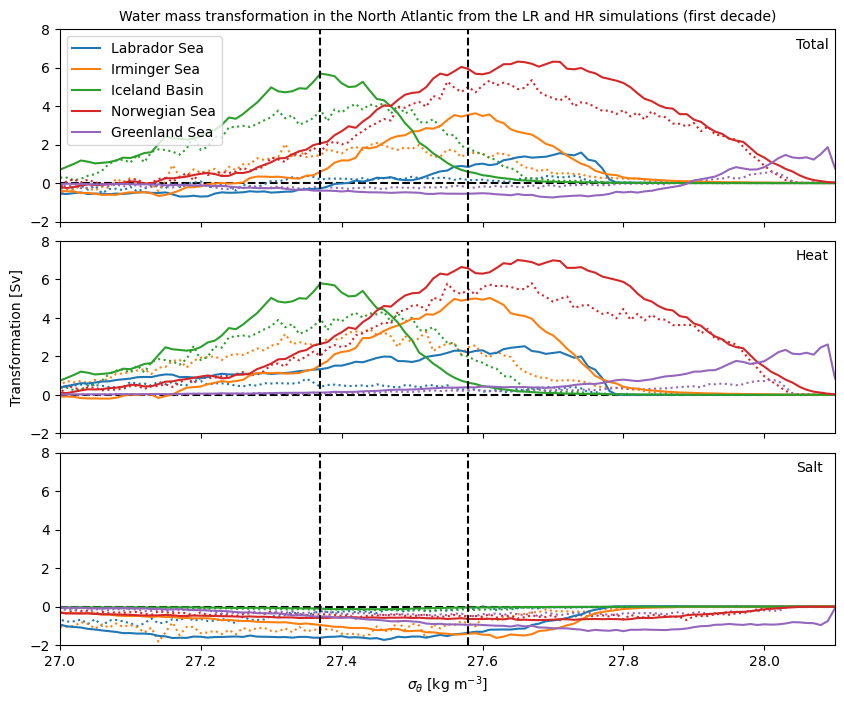

In [12]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.1})
palette = plt.get_cmap('tab10').colors
xlim, ylim = [27, 28.1], [-2, 8]

# Loop through panels and transformation categories
for ax, ctgy in zip(axs, ['Total', 'Heat', 'Salt']):
    
    # Loop through meshes and regions
    for mesh, ls in zip(['LR', 'HR'], [':', '-']):
        for region, color in zip(regions, palette):
            
            # Plot transformation averaged over first 12 months of simulation
            label = region if ls == '-' else None
            y = wmt[mesh]['1D']['density' + ctgy + 'Transformation'].sel(regionNames=region).mean(dim='time')
            x = y.densityBins
            ax.plot(x, y, ls, color=color, label=label)
    
    # Formatting
    for sigma in [27.37, 27.58]:
        ax.plot([sigma, sigma], ylim, 'k--')
    ax.plot(xlim, [0, 0], 'k--', zorder=-10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.text(0.95, 0.9, ctgy, transform=ax.transAxes)
    if ctgy != 'Salt':
        ax.xaxis.set_ticklabels('')

# Final formatting
axs[2].set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
axs[1].set_ylabel('Transformation [Sv]')
axs[0].set_title('Water mass transformation in the North Atlantic from the LR and HR simulations (first decade)')
axs[0].legend()
plt.show()

2D transformation summary

In [18]:
def plot_2D_transformation(sigmaBin):
    """Plot 2D transformation on the sigmaBin
    """
    
    # Get sigmaBin slice
    slc = slice(sigmaBin-0.05, sigmaBin+0.05)

    # Make figure
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    xlim, ylim = [-70, 20], [40, 80]

    # Loop through rows and transformation categories
    for row, ctgy in zip(axs, ['Total', 'Heat', 'Salt']):
        row[0].set_ylabel(ctgy + ' transformation')

        # Loop through panels and meshes
        residual = []
        for ax, mesh in zip(row, meshes):

            # Plot transformation averaged over first 12 months of simulation on sigmaBin
            z = wmt[mesh]['2D']['density' + ctgy + 'Transformation2D'].sel(densityBins=slc).mean(dim=['time', 'densityBins'])
            x, y = z.lon, z.lat
            c1 = ax.pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='BrBG_r')
            residual.append(z)

        # Plot residual
        residual = np.subtract(*residual[::-1])
        c2 = row[2].pcolormesh(x, y, residual, vmin=-20, vmax=20, cmap='RdBu_r')

    # Formatting
    pos = []
    for col, title in zip(axs.T, meshes + ['HR-LR']):
        col[0].set_title(title)
        pos.append(col[2].get_position())
        for ax in col:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

    # Add colorbars
    cax1 = fig.add_axes([pos[0].x0, 0.08, pos[1].x1 - pos[0].x0, 0.01])
    cax2 = fig.add_axes([pos[2].x0, 0.08, pos[2].width, 0.01])
    fig.colorbar(c1, cax1, orientation='horizontal', label='Sv')
    fig.colorbar(c2, cax2, orientation='horizontal', label='Sv')

Sigma 27.4 (LR shifted toward Irminger Sea)

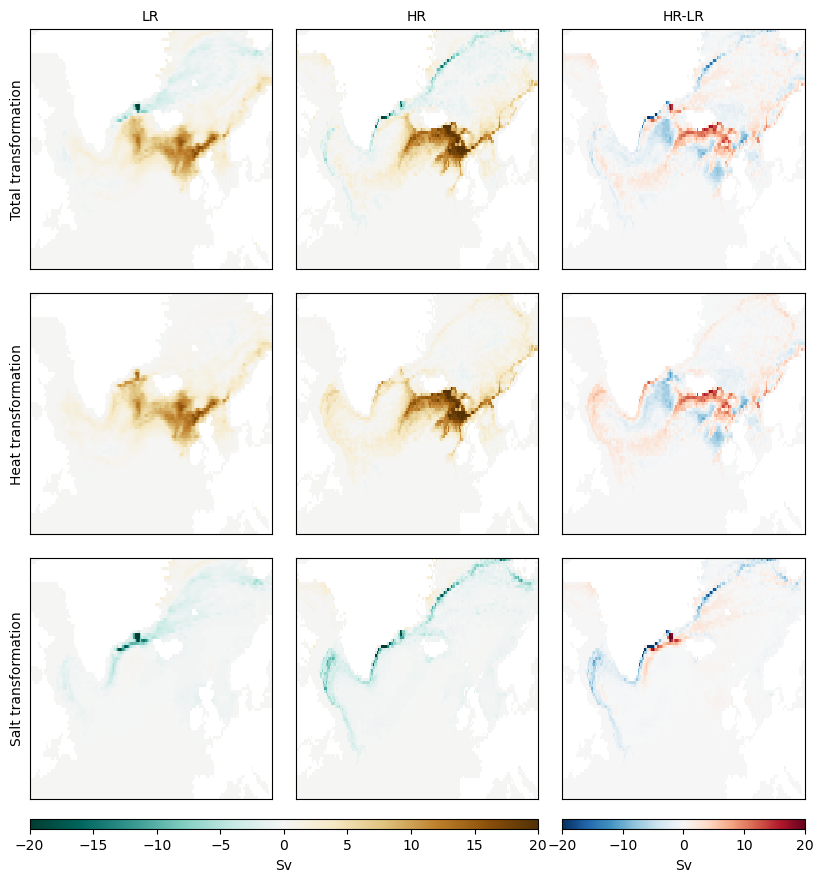

In [21]:
# Plot 2D transformation on sigma 27.4
plot_2D_transformation(27.4)

Sigma 27.6 (HR shifted away from Iceland Basin toward Irminger Sea, Lab Sea and Norwegian Sea)

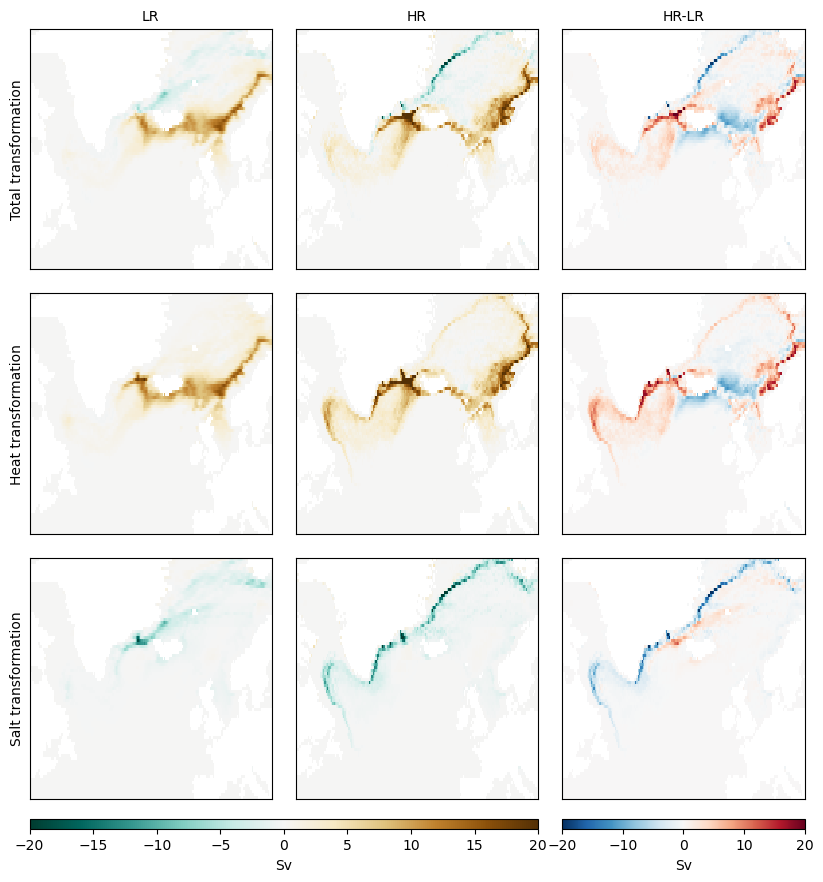

In [22]:
# Plot 2D transformation on sigma 27.6
plot_2D_transformation(27.6)